  0%|                                                                                          | 0/549 [00:00<?, ?it/s]

Filtering Database


100%|████████████████████████████████████████████████████████████████████████████████| 549/549 [00:56<00:00,  9.70it/s]


221 remaining out of 290


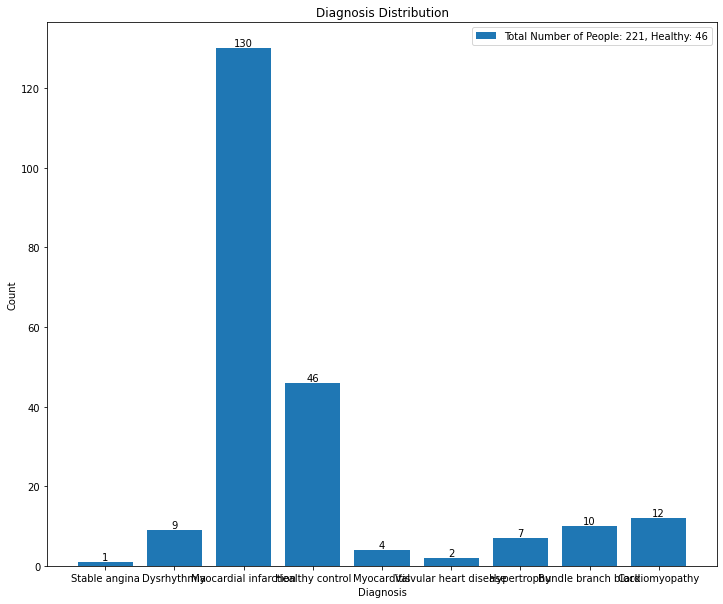

 19%|███████████████▏                                                                | 42/221 [00:00<00:00, 417.69it/s]

normalising and preproccessing signals using DWT


100%|███████████████████████████████████████████████████████████████████████████████| 221/221 [00:01<00:00, 119.54it/s]


Calculating Time Domain Features
Calculating Frequency Domain Features
Calculating Non-Linear Domain Features
Selecting the 4 most important features from 18 for each channel
Selected features for channel 0:
['rr_amps', 'mean', 'shannon_en', 'age']
Selected features for channel 1:
['rr_amps', 'shannon_en', 'sd_ratio', 'age']
Selected features for channel 2:
['rr_std', 'rr_amps', 'shannon_en', 'age']
Selected features for channel 3:
['rr_std', 'std', 'skews', 'age']
Selected features for channel 4:
['rr_amps', 'skews', 'shannon_en', 'age']
Selected features for channel 5:
['rr_std', 'RMSSD', 'mean', 'age']


In [1]:
%run "Feature_Selection.ipynb" 

In [66]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import itertools
from sklearn.multiclass import OneVsOneClassifier

In [71]:
allowed_patients.get_diagnosis_counts()

{'Stable angina': 1,
 'Dysrhythmia': 9,
 'Myocardial infarction': 130,
 'Healthy control': 46,
 'Myocarditis': 4,
 'Valvular heart disease': 2,
 'Hypertrophy': 7,
 'Bundle branch block': 10,
 'Cardiomyopathy': 12}

First we have to access the patients specific disease type. We can see from the plot that several disease types have very few entries. We shall ignore these and focus on the five classes with the most frequent appearances. We can further see that the data base is very heavily skewed....

In [72]:
detailed_health_state = []
for i in range(0, no_patients):
    detailed_health_state.append(allowed_patients.get_patients(i).get_diagnosis())

detailed_health_state = np.array(detailed_health_state)

In [73]:
#these have very few appearances in data set so are removed
diagnoses_to_remove = ['Stable angina', 'Myocarditis', 'Valvular heart disease', 'Hypertrophy']

#finding indices with which to remove from the dataset
diagnosis_indices = []
new_health_state = []
for j in range(0, no_channels):
    filter_diagnosis = []
    for diagnosis in detailed_health_state[nan_indices[j]]:
        if diagnosis in diagnoses_to_remove:
            filter_diagnosis.append(False)
        else:
            filter_diagnosis.append(True)
    diagnosis_indices.append(filter_diagnosis)
    new_health_state.append(detailed_health_state[nan_indices[j]][diagnosis_indices[j]])

In [74]:
#creating parameter array with the required data filtered out
no_features = len(selected_params[0])

params_list = []
for j in range(0, no_channels):
    params_array = np.zeros(shape=(len(new_health_state[j]), no_features))
    for i, values in enumerate(selected_params[j].values()):
        params_array[:, i] = values[diagnosis_indices[j]]
        
    params_list.append(params_array)


Scikit-learn has two major options for multiclass classification: OnevsRest and OnevsOne. One vs rest trains a bianry classifier for each class, trying to seperate it from the rest of the classes with the final classification based on the classifier with the highest confidence score. One vs one trains a seperate binary classifier for every pair of classes with the final prediction based on a majority voting scheme. OnevsRest has to train less classifiers however is not effective when dealing with the imbalanced classes that we have here. Therefor I shall attempt to use OnevsOne.

In [107]:
def tune_hyperparams(params, health_state, param_grid, scorer='balanced_accuracy'):
    
    X_train, X_test, y_train, y_test = train_test_split(params, health_state, test_size=0.3, stratify=health_state)
    
    # Standardize the features
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
    
    #initialise classifier
    ovo_svm = OneVsOneClassifier(SVC(class_weight = 'balanced', probability=True))


    # perform grid search
    grid_search = GridSearchCV(ovo_svm, param_grid, cv=3, scoring=scorer)
    
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_estimator_

In [108]:
# define hyperparameter grid to test
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10],
    'estimator__kernel': ['linear', 'rbf', 'poly'],
    'estimator__gamma': ['scale']#including 'auto' aswell takes forever
}


best_estimators = []
for i in range(0, no_channels):
    best_estimators.append(tune_hyperparams(params_list[i], new_health_state[i], param_grid))
    

In [109]:
def skfold_with_probabilities(params, health_state, n_splits, best_estimator, scorer=balanced_accuracy_score):
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) #can do repeated skf for better validation
    
    probabilities = []
    sample_percentages = []
    y_tests = []
    balanced_acc = []
    test_indices = []
    for train_index, test_index in skf.split(params, health_state):
        #getting test and train data sets
        X_train, X_test = params[train_index], params[test_index]
        y_train, y_test = health_state[train_index], health_state[test_index]
        
        
        #calculating percentage of healthy in training data
        sample_percentages.append(np.mean(y_train == 'Healthy')) #how is threshold measured??? health_state[train_index]??
        
        #fitting data on previously calculated best estimator
        best_estimator.fit(X_train, y_train)
        
        #evaluating model
        y_pred = best_estimator.predict(X_test)
        balanced_acc.append(balanced_accuracy_score(y_test, y_pred))
        
        
        #for reconstruction of full patient data
        test_indices.append(test_index)

    return np.mean(np.array(balanced_acc))

In [110]:

balanced_accuracy = []
n_splits=3

for i in range(0, no_channels):
    bal_acc = skfold_with_probabilities(params_list[i], new_health_state[i], n_splits, best_estimators[i])
    balanced_accuracy.append(bal_acc)

In [111]:
import pandas as pd

score_accuracy = [0, 0, 0, 0, 0, 0]
#presenting results as pandas df
data = {
    'Success Metric': ['Objective Score', 'Balanced Accuracy'],
    'Channel 1': [f'{score_accuracy[0]}', f'{balanced_accuracy[0]}'],
    'Channel 2': [f'{score_accuracy[1]}', f'{balanced_accuracy[1]}'],
    'Channel 3': [f'{score_accuracy[2]}', f'{balanced_accuracy[2]}'],
    'Channel 4': [f'{score_accuracy[3]}', f'{balanced_accuracy[3]}'],
    'Channel 5': [f'{score_accuracy[4]}', f'{balanced_accuracy[4]}'],
    'Channel 6': [f'{score_accuracy[5]}', f'{balanced_accuracy[5]}'],
    
}

df = pd.DataFrame(data)

df

,Success Metric,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6
0,Objective Score,0,0,0,0,0,0
1,Balanced Accuracy,0.40588588588588587,0.4102564102564103,0.43514499837080484,0.4112576312576312,0.2886507936507936,0.38877899877899874


In [ ]:
#generate confusion matrix

In [ ]:
#look at FSL